I dette prosjektet tar vi for oss et delområde innenfor maskinlæring kalt dyplæring. Dyplæring går ut på å trene opp nevrale nettverk. Dette gjøres ved å utføre transformasjoner på en rekke bilder i $K$ lag, og finne parametrene i hvert lag som gir transformasjoner med lite avvik fra en oppgitt fasit. Deretter kan disse parametrene brukes igjen for løse nye problemer.
I denne oppgaven finner vi disse parametrene og ser på utviklingen gjennom lagene. 

Først definerer vi delfunksjonene som brukes i algoritmen, deretter algoritmen som vi har valgt å dele i to hoveddeler. 
Det er to problemer vi vil implementere denne algoritmen på. Det første problemet går ut på å skille mellom blå og røde punkter beskrevet av $2$ koordinater. Det andre er siffergjenkjenning i et bilde på $28 x 28$ piksler, hvor vi velger å se på to forskjellige siffer.

I kodecelle nummer 2 velges hvilket problem algoritmen skal kjøres på, og hvilken metode som skal brukes for å oppdatere vekter og bias.

### Funksjoner

In [2]:
from spirals import *
from loader import *
from plotting import *
from saveLoad import *
import matplotlib.pyplot as plt
import random as rnd


# Todo Oppgitte funksjoner
def sigma(x: float):
    return np.tanh(x)


def dSigmadx(x):
    return 1 / np.cosh(x) ** 2


def eta(x):
    return (1 + np.tanh(x / 2)) / 2


def detadx(x):
    return 1/(2 * np.cosh(x) + 2)


def Z(YK, omega, mu):
    return eta(YK.T @ omega + mu*en)


def J(c, YK, omega, mu):
    return np.sum(abs(Z(YK, omega, mu) - c) ** 2) / 2


def PK(omega, Zmc, YK, mu):
    return omega @ ((Zmc * detadx(YK.T @ omega + mu)).T)


def PkPrev(P_kList, h, W_k, Y_kList, b_kList):
    tempPk = P_kList[-1]
    for k in range(1, K + 1):
        easeOfRead = dSigmadx(W_k[-k] @ Y_kList[-k] + b_kList[-k])
        tempPk = tempPk + h * W_k[-k].T @ (easeOfRead * tempPk)
        P_kList[-k - 1] = tempPk
    return P_kList


# todo Divergens
def dJdmu(YK, omega, mu, zminusc):
    return detadx(YK.T @ omega + mu * en).T @ zminusc


def dJdomega(YK, omega, mu, zminusc):
    return YK @ (zminusc * detadx(YK.T @ omega + mu))


def dJdW(h, P_kList, W, Y_kList, b_k, djdW):
    for k in range(0, K):
        djdW[k] = (h * (P_kList[k + 1] * dSigmadx(W[k] @ Y_kList[k] + b_k[k])) @ Y_kList[k].T)
    return np.array(djdW)


def dJdb(h, P, W, Y, b, djdb):
    for k in range(K):
        djdb[k] = h * (P[k + 1] * dSigmadx(W[k] @ Y[k] + b[k])) @ en
    return djdb


def algoritme(W, b, omega, mu, Y, P, h, K, djdW, djdb, j, m=[], v=[], adam=False, labels=[]):
    for k in range(0, K):
        Y[k + 1] = Y[k] + h * sigma(W[k] @ Y[k] + b[k])

    z = Z(Y[-1], omega, mu) #Gamma in nummat
    Zmc = z - labels #Gmc in nummat
    J = 0.5 * np.linalg.norm(Zmc) ** 2
    
    if bilder:
        if j % 10 == 0 or j == 1:
            print('J_{} = {}'.format(int(j), J))
    else:
        if j % 10000 == 0 or j == 1:
            print('J_{}k = {}'.format(int(j/1000), J))

    # Forrige PK
    P[-1] = PK(omega, Zmc, Y[-1], mu)
    P = PkPrev(P, h, W, Y, b)  # (K+1, 2, I)

    # Divergenser
    # Tomme arrays
    djdmu = dJdmu(Y[-1], omega, mu, Zmc)
    djdomega = dJdomega(Y[-1], omega, mu, Zmc)
    # Finner divergens
    djdW = dJdW(h, P, W, Y, b, djdW)
    djdb = dJdb(h, P, W, Y, b, djdb)

    if adam:
        newW, m[0], v[0] = Adam(djdW, W, m[0], v[0], j)
        newb, m[1], v[1] = Adam(djdb, b, m[1], v[1], j)
        newomega, m[2], v[2] = Adam(djdomega, omega, m[2], v[2], j)
        newmu, m[3], v[3] = Adam(djdmu, mu, m[3], v[3], j)
        return newW, newb, newomega, newmu[0][0], m, v, J
    else:
        newW = W - tau * djdW
        newb = b - tau * djdb
        newomega = (omega - tau * djdomega)
        newmu = (mu - tau * djdmu)
        return newW, newb, newomega, newmu, J


def generations(W, b, omega, mu, h, K, J=5000, adam=False, bilder=False, plot=False):
    if bilder:
        print('Kjører med bilder')
        Y0, labels = get_dataset(dataset="training",
                                 path=r"C:\PycharmProjects\Mekfys\4.Semester\Vitber\Prosjekt_2_Deep_Learning")
        labels = labels[0:I]
        Y0 = Y0[:, 0:I]
    else:
        Y0, labels = get_data_spiral_2d(I)
    labels = np.array(labels)

    # Setter av minne til de store listene
    P = np.empty((K + 1, d, I))
    Y = np.empty((K + 1, d, I))
    djdW = np.empty((K, d, d))
    djdb = np.empty((K, d, 1))


    Y[0] = Y0

    Wnew, bNew, omegaNew, muNew = W, b, omega, mu
    
    Jl=[]
    genl=[]
    
    if adam:
        j = 1
        m = [np.zeros((K, d, d)), np.zeros((K, d, 1)), np.zeros((d, 1)), m0]
        v = [np.zeros((K, d, d)), np.zeros((K, d, 1)), np.zeros((d, 1)), v0]
        while j < J + 1:
            Wnew, bNew, omegaNew, muNew, m, v, Jr = algoritme(Wnew, bNew, omegaNew, muNew, Y, P, h, K,
                                                          djdW, djdb, j, m, v, adam, labels)
            Jl.append(Jr)
            genl.append(j)
            j += 1

    else:
        j = 0
        while j < J:
            Wnew, bNew, omegaNew, muNew = algoritme(Wnew, bNew, omegaNew, muNew,
                                                    Y, P, h, K,djdW, djdb, j)
            Jl.append(Jr)
            genl.append(j)
            j += 1


    for k in range(0, K):
        Y[k + 1] = Y[k] + h * sigma(Wnew[k] @ Y[k] + bNew[k])

    z = Z(Y[-1], omegaNew, muNew)
    Zmc = z - labels



    feil = 0
    for i in Zmc:
        if 0.5 <= abs(i):
            feil += 1

    print('\nfeil: {}%\n'.format(feil / I * 100))

    if not bilder and plot:
        plot_progression(Y, labels)
    return Wnew, bNew, omegaNew, muNew, Jl, genl


# ADAM descent algorithm for en parameter
def Adam(gj, UPrev, mPrev, vPrev, j):
    mj = b1*mPrev + (1-b1)*gj
    vj = b2*vPrev + (1-b2)*(gj*gj)
    mHatt = mj / (1-b1**j)
    vHatt = vj / (1-b2**j)
    Uj = UPrev - a*mHatt / (np.sqrt(vHatt) + epsilon)
    return Uj, mj, vj


Now on run 2.
Time elapsed 0:00:00.002998
Gamma[35] =  0.89238701738774
C[35] =      0.908785046728972


Now on run 1000.
Time elapsed 0:00:03.219857
Gamma[35] =  0.8707245542559385
C[35] =      0.908785046728972


Now on run 2000.
Time elapsed 0:00:06.522895
Gamma[35] =  0.8845282049972374
C[35] =      0.908785046728972


Now on run 3000.
Time elapsed 0:00:09.754041
Gamma[35] =  0.8878153548631831
C[35] =      0.908785046728972


Now on run 4000.
Time elapsed 0:00:13.080582
Gamma[35] =  0.8911406535818409
C[35] =      0.908785046728972


Now on run 5000.
Time elapsed 0:00:16.321467
Gamma[35] =  0.8968077881523958
C[35] =      0.908785046728972


Now on run 6000.
Time elapsed 0:00:20.246294
Gamma[35] =  0.9031912467797021
C[35] =      0.908785046728972




KeyboardInterrupt: 

J_0k = 34.75066525071522
J_5k = 0.008736891109553111
J_10k = 0.0005374563238777305
J_15k = 4.1787195881278427e-05
J_20k = 2.224705498228687e-06
J_25k = 2.72901151137803e-07
J_30k = 3.236635555857013e-08
J_35k = 5.348304564679764e-09
J_40k = 2.1254319453381246e-09

feil: 0.0%



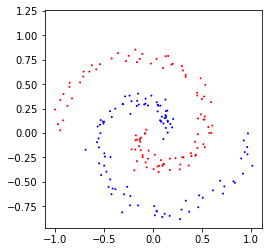

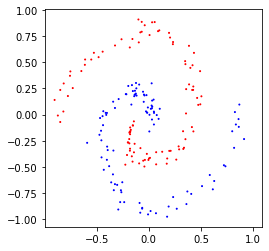

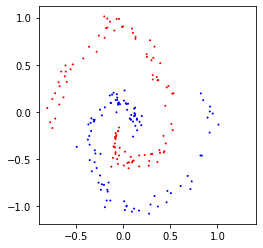

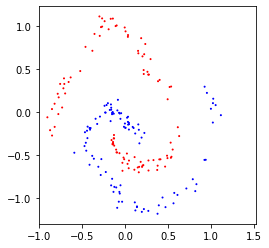

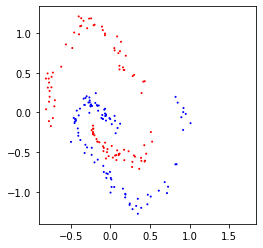

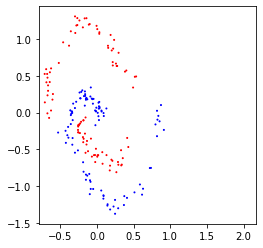

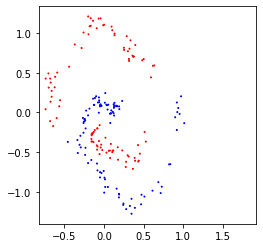

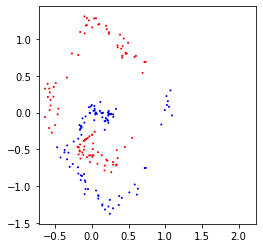

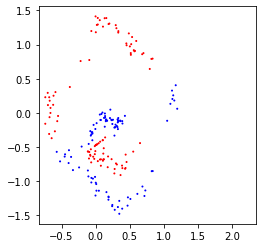

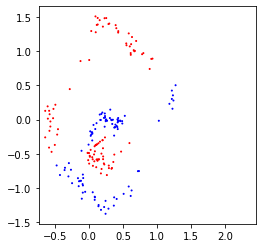

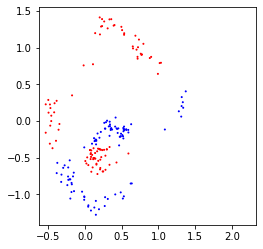

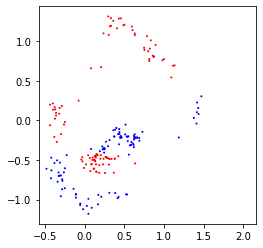

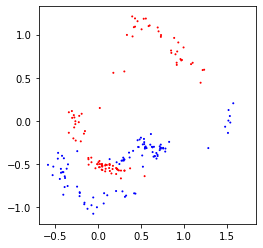

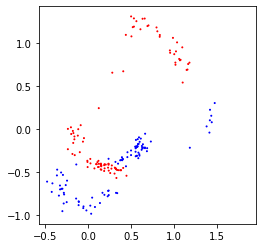

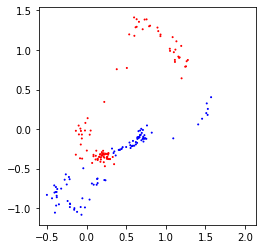

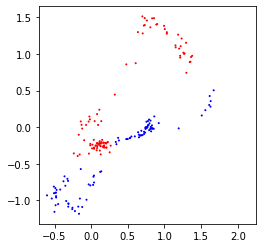

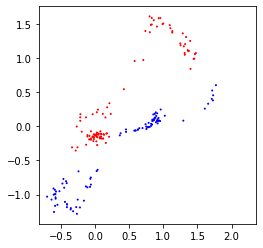

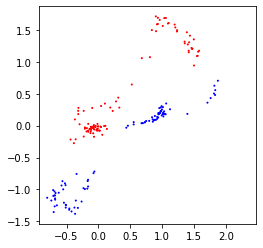

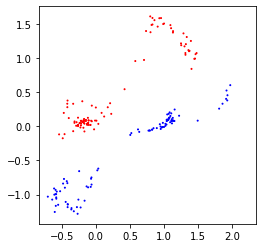

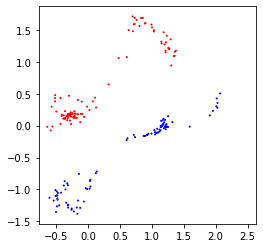

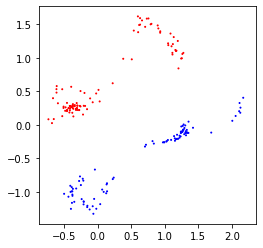

In [18]:
h = 0.1
tau = 0.1 # Læringsparameter
I = 200  # Antall bilder
en = np.ones((I, 1))
d = 2
gens = 40000
K = 20  # antall lag

# Bilder bestemmer hvorvidt vi kjører koden på spiralpunkter eller sifferbilder 
bilder = False
# bilder = True
if bilder:
    d = 28*28
    I = 20
    gens = 100
    K = 10
    en = np.ones((I, 1))

# Laste inn gamle parametre
# W, b, omega, mu, K = loadParams()

# Opprette nye tilfeldige parametre
W = np.random.random((K, d, d))
b = np.random.random((K, d, 1))
omega = np.random.random((d, 1))
mu = rnd.random()


#Tidligere funnet parametre:
# W = loadW()


#Variabler til Adam
b1 = 0.9
b2 = 0.999
a = 0.01
epsilon = 10e-8
v0 = 0
m0 = 0

#Om du ønsker Adam descent algorithm eller ikke.
adam = True
# adam = False

Wnew, bNew, omegaNew, muNew, Jl, genl= generations(W, b, omega, mu, h, K, gens, adam, bilder, True)
# For å lagre parametre
# saveParams(Wnew, bNew, omegaNew, muNew)


Her ser vi visualiseringen av problemet og forskyvning til punktene gjennom $K$ lag med transformasjoner. Målet er å skille blå og røde prikker fra hverandre, og ovenfor ser vi bilder av utviklingen. I de siste bildene ser vi at blåe og røde prikker er skilt fra hverandre.

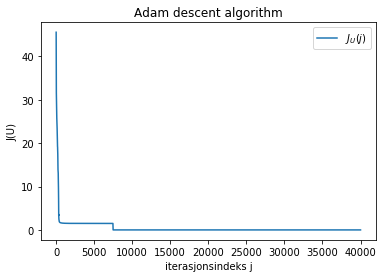

In [34]:
if adam:
    plt.title('Adam descent algorithm')
else:
    plt.title('Plain vanilla gradient descent')
plt.plot(genl, Jl, label=r'$J_U(j)$')
plt.xlabel('iterasjonsindeks j')
plt.ylabel('J(U)')
plt.legend()
plt.show()

Vi ønsker å minimere $J(U)$. Vi ser her hvordan $J(U)$ utvikler seg som funksjon av iterasjonsindeksen $j$.

In [30]:

d = 2
for K in range(1,21,3):
    W = np.random.random((K, 2, 2))
    b = np.random.random((K, 2, 1))
    omega = np.random.random((d, 1))
    mu = rnd.random()
    print('Lag:', K)
    Wnew, bNew, omegaNew, muNew, Jl, genl= generations(W, b, omega, mu, h, K, gens, adam, bilder)
    print('\n\n')

Lag: 1
J_0k = 44.15249500449192
J_5k = 30.521443743862676
J_10k = 21.19094469029969
J_15k = 21.12542467524268
J_20k = 21.095392626072574
J_25k = 21.083397689624743
J_30k = 21.07893170024827
J_35k = 21.07727840973218
J_40k = 21.0766582662189

feil: 48.5%




Lag: 4
J_0k = 42.995863693789765
J_5k = 17.926283084362133
J_10k = 16.854618371192714
J_15k = 14.966783849723786
J_20k = 14.980455521434966
J_25k = 14.977984137777616
J_30k = 14.967371557957613
J_35k = 15.987699083439852
J_40k = 15.80626313649514

feil: 16.0%




Lag: 7
J_0k = 33.9805309967327
J_5k = 0.5064162217753353
J_10k = 0.5002919943420318
J_15k = 8.504178673354581e-05
J_20k = 8.418890668623054e-06
J_25k = 7.597705330504152e-07
J_30k = 9.294418053358681e-08
J_35k = 1.9749648517856765e-08
J_40k = 9.208331681675869e-09

feil: 0.0%




Lag: 10
J_0k = 37.351665172031844
J_5k = 0.0026058041807257054
J_10k = 0.00016325401518519305
J_15k = 1.3503178385158522e-05
J_20k = 1.0928908582320909e-06
J_25k = 1.0859546425752822e-07
J_30k = 1.

Ovenfor ser vi hvordan prosentandelen feil endrer seg når vi varierer antall lag $K$. Her er antall iterasjoner 40000. Vi ser at prosentandelen feil rakst avtar når vi går fra 1 lag til 4 lag, men prosentandelen feil avtar saktere når lagene øker etter lag 4. Fra lag 7 til 10 ser vi også en økning i prosentandel feil, men etter dette ser det ut til at prosentandel feil stabiliseres seg på 0 når vi har 16 lag og over. 